In [1]:
HOST = '37.139.42.145'
DBNAME = 'game-analytics'
USER = 'analytics'
PASSWORD = 'BRtTaqYiJyr29WXN'
import pandas as pd
from sqlalchemy import create_engine
engine = create_engine(f'postgresql://{USER}:{PASSWORD}@{HOST}/{DBNAME}')
TABLE_SCHEMA ='data_viz_1068.project_dataset'

In [16]:
rr=pd.read_sql(f'''
with data as
(select event_time, platform, user_type, user_id, 
    min(event_time) filter (WHERE event_name = 'FirstLaunchApp') OVER (PARTITION BY user_id) as install_time, 
    case when country in ('RU', 'BY','TJ','KG', 'AM', 'AZ', 'UZ') then 'CIS'
    when country in ('MD', 'DK', 'BE', 'FI', 'SE', 'IE', 'PT', 'GR', 'SI', 'UA', 'CZ', 
    'PL', 'EE', 'DE', 'RO', 'LV', 'UK', 'LT', 'ES', 'SK', 'HU', 'HR', 'FR', 'IT', 'LU', 'NL', 'AT', 'BG') then 'Europe'
    when country in ('US', 'CA') then 'North America' else 'other' end as region
from data_viz_1068.project_dataset
where user_id in 
        (select user_id
         from data_viz_1068.project_dataset
         where event_name = 'FirstLaunchApp')
         and event_name in ('FirstLaunchApp','LaunchApp'))
         
select user_id, platform, region, user_type, 
   max (extract(hour from date_trunc ('hours', event_time-install_time))) as life_time
from data
where event_time <= (install_time + interval '1' day)
group by user_id, platform, region, user_type
''', con=engine)
temp_df = pd.DataFrame({'lifehour_rolling':range(0,24)})
temp_df['merge'] = 1
rr['merge'] = 1
rolling_df = pd.merge(temp_df, rr, on = 'merge')
rolling_df = rolling_df[rolling_df['life_time'] >= rolling_df['lifehour_rolling']]
rolling_df = rolling_df.groupby(['lifehour_rolling', 'region', 'platform', 'user_type'], as_index=0).agg({'user_id':'nunique'})
#rolling_df.to_csv('./desktop/rolling_df.csv', index=False)

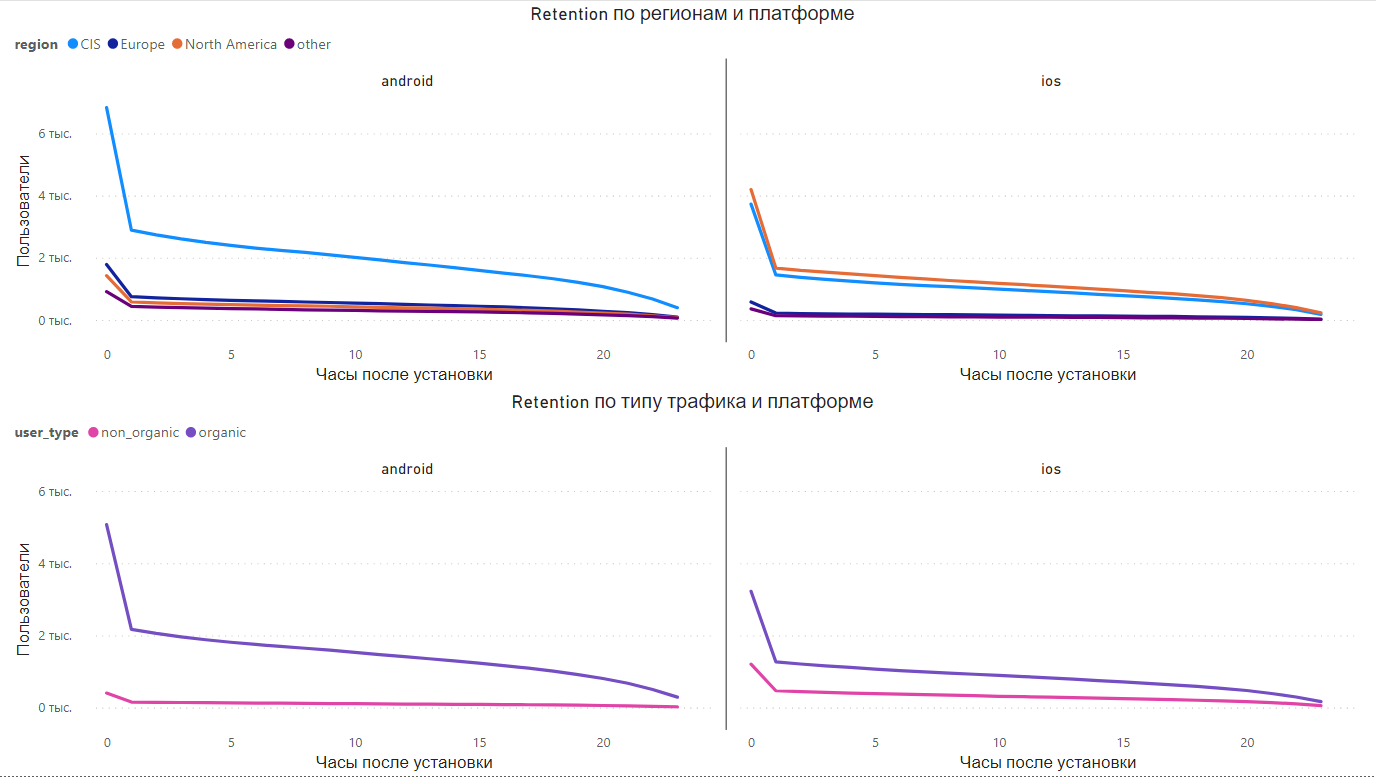

Вывод: Согласно графику, возврат пользователей в игру за первые 24 часа больще всего в СНГ (на второй час 50%), в разрезе платформ андройд. При этом по графику ниже, можно заметить, что это пользователи органического трафика. В платформе iOS Retention в СНГ находится примерно на одинаковом уровне с Северной Америкой, это так же пользователи органического трафика. У пользователей неорганического трафика Retention стремится к нулю во всех когортах.

In [18]:
ret=pd.read_sql(f'''
with data as
(select event_time, platform, user_type, user_id, 
    min(event_time) filter (WHERE event_name = 'FirstLaunchApp') OVER (PARTITION BY user_id) as install_time, 
    case when country in ('RU', 'BY','TJ','KG', 'AM', 'AZ', 'UZ') then 'CIS'
    when country in ('MD', 'DK', 'BE', 'FI', 'SE', 'IE', 'PT', 'GR', 'SI', 'UA', 'CZ', 
    'PL', 'EE', 'DE', 'RO', 'LV', 'UK', 'LT', 'ES', 'SK', 'HU', 'HR', 'FR', 'IT', 'LU', 'NL', 'AT', 'BG') then 'Europe'
    when country in ('US', 'CA') then 'North America' else 'other' end as region
from data_viz_1068.project_dataset
where user_id in 
        (select user_id
         from data_viz_1068.project_dataset
         where event_name = 'FirstLaunchApp')
         and event_name in ('FirstLaunchApp','LaunchApp'))
 
 select  life_time ,platform, user_type, region, cast(users as float)/cast(installs as float)*100 as retention
 from
(select life_time, count(distinct user_id) as users, platform, user_type, region, 
max(count(distinct user_id)) over (partition by platform, user_type, region) as installs
from 
(select user_id, platform, region, user_type, 
   max (extract(day from date_trunc ('days', event_time-install_time))) as life_time
from data
group by user_id, platform, region, user_type) as y
where life_time between '0' and '30'
group by life_time ,platform, user_type, region) as s
''', con=engine)

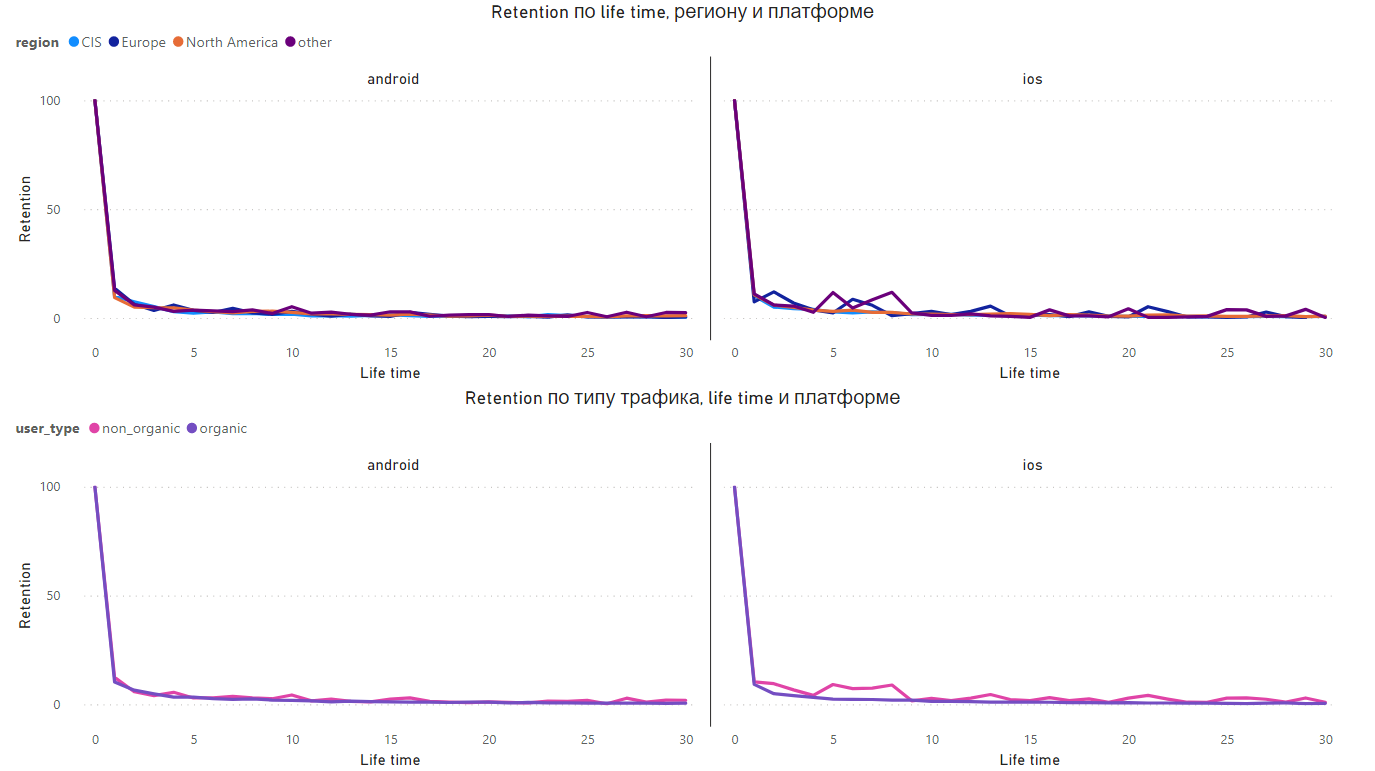

Вывод: У пользователей андройд Retention находится примерно на одинаковом уровне во всех регионах. В iOS выделяется Retention в Европе и других регионах. Рассматривая типы трафика, в iOS Retention неорганического трафика выше, но стоит помнить, что число установок ниже.  В первом задании казалось что возврат игроков преобладает в СНГ на платформе андройд, но в разрезе 30 дней, мы видим, что он не отличается от остальных.

In [15]:
ret=pd.read_sql(f'''
with data as
(select event_time, user_id, event_name,
    min(event_time) filter (WHERE event_name = 'FirstLaunchApp') OVER (PARTITION BY user_id) as install_time
    from data_viz_1068.project_dataset
where user_id in 
        (select user_id
         from data_viz_1068.project_dataset
         where event_name = 'FirstLaunchApp')
         and event_name in ('FirstLaunchApp','LaunchApp')and user_type = 'non_organic')
 
select life_time, month, cast(users as float)/cast(installs as float)*100 as retention
from
(select life_time, count(distinct user_id) as users, month, 
max(count(distinct user_id)) over (partition by month) as installs
from
(select user_id,
   max (extract(day from date_trunc ('days', event_time-install_time))) as life_time, 
   to_char(date_trunc('month',min(event_time)filter (where event_name = 'FirstLaunchApp')),'YYYY-MM') as month
from data
group by user_id) as a
where life_time between '0' and '30'
group by life_time, month) as c
order by life_time, month
''', con=engine)
ret = ret.pivot_table(index = ['month'], columns = 'life_time', values = 'retention').fillna(0).reset_index()
#ret.to_csv('./desktop/ret4.csv', index=False)

https://docs.google.com/spreadsheets/d/1SW6t2Uv3NDKmOucfxLkXf_6UF5RV1pbT9CQycpOMB44/edit?usp=sharing
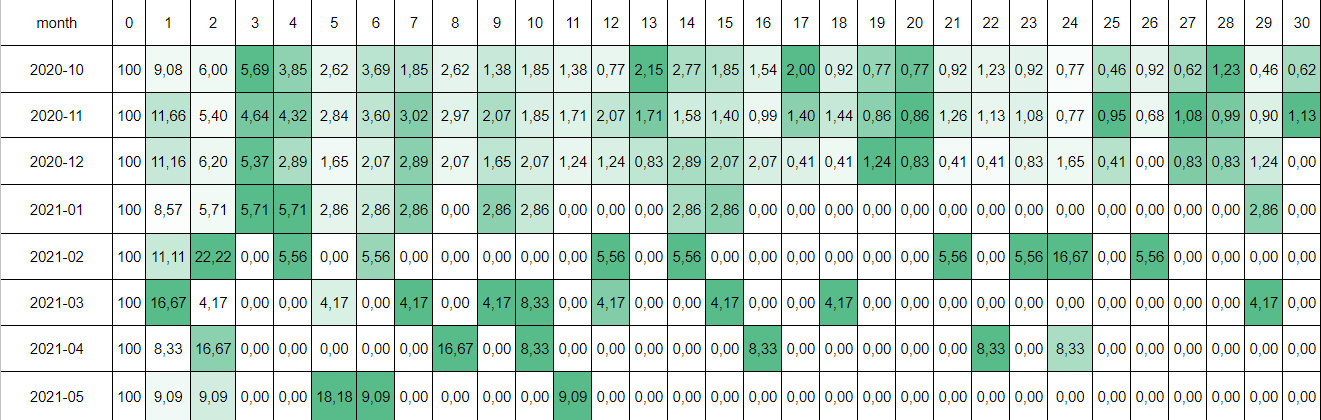

Вывод: Рассматриваемая таблица относится к Retention rate 30 в разрезе месяца установки для неорганического трафика. Говоря о R1, то уже можно предположить, что возврат игроков очень низкий. Возможно это связано с тем, что закупочные кампании настроены не на целевую аудиторию. В среднем R1 не превышает 12%. Говоря о R30, можно сделать выводы, что прибыль проекта будет очень низкой в случае продолжения закупки трафика у данных кампаний, так как R30 имеет наибольший процент 1,13 у игроков, которые установили игру в ноябре 2020 года.